Names: Philipp Köhler, Alexander Bespalov


# Sheet 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import pyplot as plt
%matplotlib inline

## 1 Principal Component Analysis
### (a)

In [2]:
np.ones((2,1))

array([[1.],
       [1.]])

In [33]:
# TODO: implement PCA (fill in the blanks in the function below)

def pca(data, n_components=None):
    """
    Principal Component Analysis on a p x N data matrix.
    
    Parameters
    ----------
    data : np.ndarray
        Data matrix of shape (p, N).
    n_components : int, optional
        Number of requested components. By default returns all components.
        
    Returns
    -------
    np.ndarray, np.ndarray
        the pca components (shape (n_components, p)) and the projection (shape (n_components, N))

    """
    # set n_components to p by default
    n_components = data.shape[0] if n_components is None else n_components
    assert n_components <= data.shape[0], f"Got n_components larger than dimensionality of data!"
    
    # center the data
    C = (np.eye(data.shape[1]) - np.ones((data.shape[1],1)) @ np.ones((data.shape[1],1)).T/data.shape[1])
    x_centered = data @ C
    
    # compute X times X transpose
    xxt = x_centered @ x_centered.T
    
    # compute the eigenvectors and eigenvalues
    eigenvalues, eigenvectors = np.linalg.eig(xxt)
    
    # sort the eigenvectors by eigenvalue and take the n_components largest ones
    sorted_indices = np.argsort(eigenvalues)[::-1]
    components = eigenvectors[:, sorted_indices][:, :n_components].T #directly use only first n_components and traspose for correct dimensions
    
    # compute X_projected, the projection of the data to the components
    X_projected = components @ x_centered
    
    return components, X_projected  # return the n_components first components and the pca projection of the data


In [34]:
# Example data to test your implementation 
# All the asserts on the bottom should go through if your implementation is correct

data = np.array([
    [ 1,  0,  0, -1,  0,  0],
    [ 0,  3,  0,  0, -3,  0],
    [ 0,  0,  5,  0,  0, -5]
], dtype=np.float32)

# add a random offset to all samples. it should not affect the results
data += np.random.randn(data.shape[0], 1)

n_components = 2
components, projection = pca(data, n_components=n_components)  # apply your implementation

# the correct results are known (up to some signs)
true_components = np.array([[0, 0, 1], [0, 1, 0]], dtype=np.float32)
true_projection = np.array([
    [ 0,  0,  5,  0,  0, -5],
    [ 0,  3,  0,  0, -3,  0]
], dtype=np.float32)

# check that components match, up to sign
assert isinstance(components, np.ndarray), f'Expected components to be numpy array but got {type(components)}'
assert components.shape == true_components.shape, f'{components.shape}!={true_components.shape}'
assert np.allclose(np.abs(components * true_components).sum(1), np.ones(n_components)), f'Components not matching'

# check that projections agree, taking into account potentially flipped components
assert isinstance(projection, np.ndarray), f'Expected projection to be numpy array but got {type(projection)}'
assert projection.shape == (n_components, data.shape[1]), f'Incorrect shape of projection: Expected {(n_components, data.shape[1])}, got {projection.shape}'
assert np.allclose(projection, true_projection * (components * true_components).sum(1, keepdims=True), atol=1e-6), f'Projections not matching'

print('Test successful!')

Test successful!


### (b)

Load the data (it is a subset of the data at https://opendata.cern.ch/record/4910#)

In [50]:
features = np.load('data/dijet_features.npy')
labels = np.load('data/dijet_labels.npy')
label_names = ['b', 'c', 'q']  # bottom, charm or light quarks

print(f'{features.shape=}, {labels.shape=}')  # print the shapes

# TODO: print how many samples of each class are present in the data (hint: numpy.unique)
unique_labels, counts = np.unique(labels, return_counts=True)

for label, count in zip(unique_labels, counts):
    print(f'Class {label_names[int(label)]}: {count} samples')

features.shape=(116, 2233), labels.shape=(2233,)
Class b: 999 samples
Class c: 864 samples
Class q: 370 samples


Normalize the data

In [51]:
# TODO: report range of features and normalize the data to zero mean and unit variance

feature_min = np.min(features, axis=0)  
feature_max = np.max(features, axis=0)  
feature_range = feature_max - feature_min  

print("Feature ranges (min, max):")
for i in range(features.shape[1]):
    print(f"Feature {i}: min={feature_min[i]}, max={feature_max[i]}, range={feature_range[i]}")

mean = np.mean(features, axis=0)
std_dev = np.std(features, axis=0)

normalized_features = (features - mean) / std_dev

print("\nNormalized Features:")
print(f"Mean of normalized features: {np.mean(normalized_features, axis=0)}")
print(f"Standard deviation of normalized features: {np.std(normalized_features, axis=0)}")
print(mean.shape)

Feature ranges (min, max):
Feature 0: min=-22553.630434111634, max=851434.4176338087, range=873988.0480679204
Feature 1: min=-18006.853037801648, max=279510.944794363, range=297517.7978321646
Feature 2: min=-30073.731746246252, max=455349.84046054434, range=485423.57220679056
Feature 3: min=-19002.889120511518, max=275234.0183880674, range=294236.9075085789
Feature 4: min=-21257.184940075487, max=785918.5791171675, range=807175.764057243
Feature 5: min=-8084.8463751906675, max=303852.3696492242, range=311937.21602441487
Feature 6: min=-20639.34793416515, max=720736.3127049857, range=741375.6606391509
Feature 7: min=-24133.763360663666, max=215399.7499735651, range=239533.51333422877
Feature 8: min=-14253.630000000001, max=564725.4293783179, range=578979.0593783179
Feature 9: min=-22789.378129673732, max=389090.86738143396, range=411880.24551110767
Feature 10: min=-22386.726229907625, max=623000.1518968535, range=645386.8781267611
Feature 11: min=-8040.025464162427, max=239518.052530029

### (c)
Compute a 2D PCA projection and make a scatterplot of the result, once without color, once coloring the dots by label. Interpret your results.

In [55]:
# TODO: apply PCA as implemented in (a)
n_components = 2
components, projection = pca(normalized_features, n_components=n_components)

c:\Users\sasch\miniconda3\envs\mlph\lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\sasch\miniconda3\envs\mlph\lib\site-packages\matplotlib\collections.py:197: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


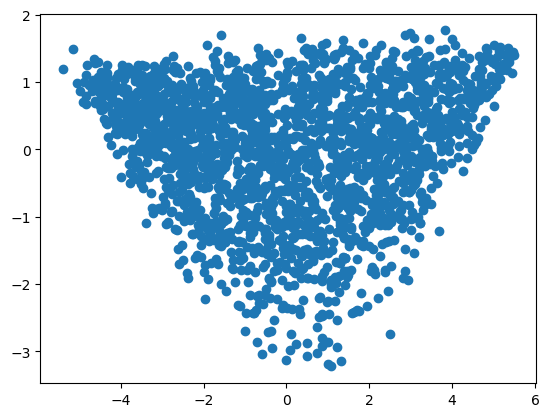

In [57]:
# TODO: make a scatterplot of the PCA projection
plt.scatter(projection[0], projection[1])

No clusters of classes can be seen. The data has a conical shape.

c:\Users\sasch\miniconda3\envs\mlph\lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\sasch\miniconda3\envs\mlph\lib\site-packages\matplotlib\collections.py:197: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


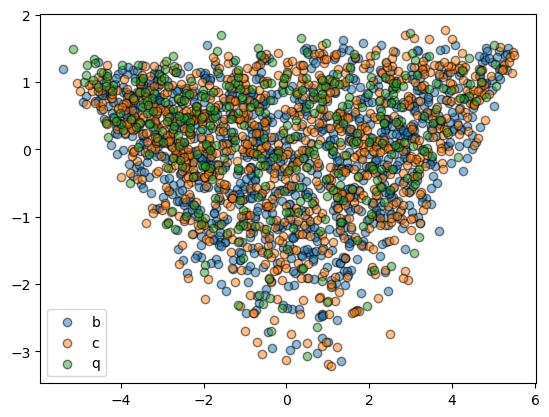

In [65]:
# TODO: make a scatterplot, coloring the dots by their label and including a legend with the label names
# (hint: one way is to call plt.scatter once for each of the three possible labels. Why could it be problematic to scatter the data sorted by labels though?)
for label in np.unique(labels):
    plt.scatter(
        projection[0][labels == label],  
        projection[1][labels == label],  
        label=label_names[int(label)],                  
        alpha=0.5,                         
        edgecolor='k'                              
    )
plt.legend()

The different classes are well mixed such that no distinct clusters can be seen. All classes have a conical shape.

## 2 Nonlinear Dimension Reduction

In [64]:
import umap  # import umap-learn, see https://umap-learn.readthedocs.io/

In [ ]:
# if you have not done 1(b) yet, you can load the normalized features directly:
features = np.load('data/dijet_features_normalized.npy')
labels = np.load('data/dijet_labels.npy')
label_names = ['b', 'c', 'q']  # bottom, charm or light quarks

### (a)

In [67]:
# TODO: Apply umap on the normalized jet features from excercise 1. It will take a couple of seconds.
# note: umap uses a different convention regarding the feature- and sample dimension, N x p instead of p x N!

reducer = umap.UMAP()
umap_projection = reducer.fit_transform(normalized_features.T)

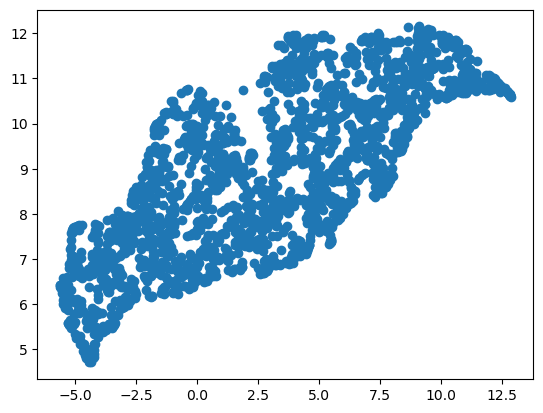

In [72]:
# TODO: make a scatterplot of the UMAP projection
plt.scatter(umap_projection[:,0], umap_projection[:,1])

Again no clustering is observable.

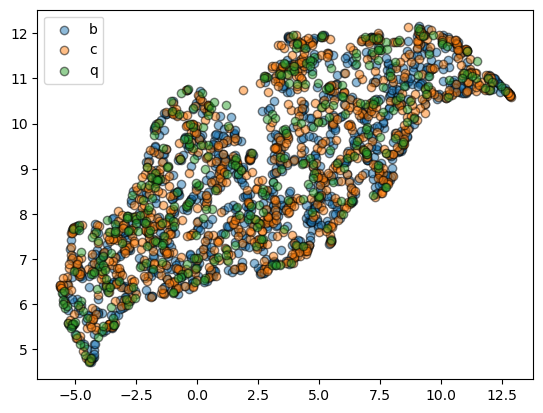

In [73]:
# TODO: make a scatterplot, coloring the dots by their label and including a legend with the label names
for label in np.unique(labels):
    plt.scatter(
        umap_projection[labels == label, 0],
        umap_projection[labels == label, 1],  
        label=label_names[int(label)],             
        alpha=0.5,          
        edgecolor='k'                         
    )
plt.legend()

The colors show again that all classes are mixed, such that no clustering is visible.

### (b)

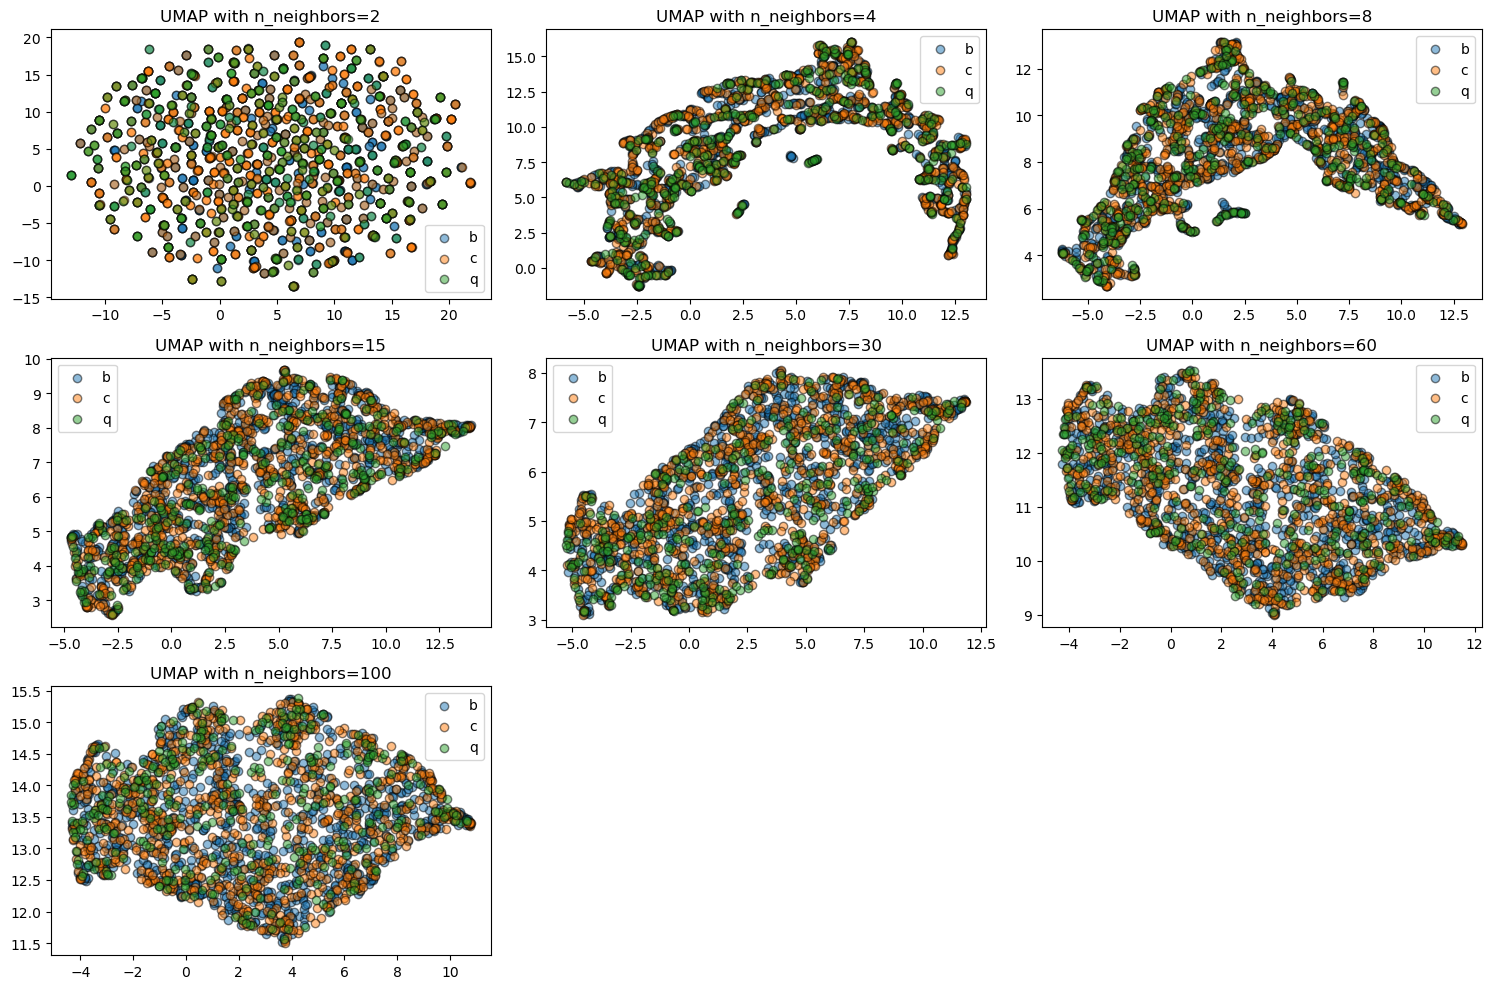

In [76]:
plt.figure(figsize=(15, 10))

n_neighbors_values = (2, 4, 8, 15, 30, 60, 100)

for i, n_neighbors in enumerate(n_neighbors_values):
    reducer = umap.UMAP(n_neighbors=n_neighbors)
    umap_projection = reducer.fit_transform(normalized_features.T)
    
    # Create a subplot for the current n_neighbors
    plt.subplot(3, 3, i + 1)  # 3 rows, 3 columns
    plt.title(f'UMAP with n_neighbors={n_neighbors}')
    
    for label in np.unique(labels):
        plt.scatter(
            umap_projection[labels == label, 0],  
            umap_projection[labels == label, 1],  
            label=label_names[int(label)],        
            alpha=0.5,                            
            edgecolor='k'                         
        )
    plt.legend()
    
    
#plt.subplot(3, 3, len(n_neighbors_values))  # Select the last subplot for the legend
#plt.legend(title='Label', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.tight_layout()  
plt.show()   

The shape of the projected data changes depending on the number of neighbours but still no clustering of the classes is visible.

## 3 RANSAC

Probability to sample $m$ inliers: $$p^m$$
Probabiltiy to not sample $m$ inliers: $$1-p^m$$
Probability to sample $r$ times not $m$ inliers: $$(1-p^m)^r$$
Probability to not sample $r$ times not $m$ inliers: $$1-(1-p^m)^r \overset{!}{=} 0.99$$
$$ \Leftrightarrow r = \frac{log(1-0.99)}{log(1-p^m)}$$

## 4 Bonus: PCA meets Random Matrix Theory

### (a)

The directional distribution of all principal componets is isotropic gaussian, because they are random variables of an isotropic gaussian distributed random variable $\mathbf{X}$ with PCA applied wich conserves the property due to linearity.

### (b)

Largest eigenvalues will grow with $N$. Middle eigenvalues are influenced by the ratio of $p$ and $N$. Most eigenvalues will be zero.

### (c)

According to Marchenko–Pastur the probability mass of the eigenvalues is in the reange of $(1\pm\sqrt{\lambda})^2$.